In [ ]:
pip install transformers torch


[0]	validation_0-mlogloss:1.59836
[1]	validation_0-mlogloss:1.58952
[2]	validation_0-mlogloss:1.57621
[3]	validation_0-mlogloss:1.56730
[4]	validation_0-mlogloss:1.55634
[5]	validation_0-mlogloss:1.54737
[6]	validation_0-mlogloss:1.53732
[7]	validation_0-mlogloss:1.52868
[8]	validation_0-mlogloss:1.51779
[9]	validation_0-mlogloss:1.51031
[10]	validation_0-mlogloss:1.50153
[11]	validation_0-mlogloss:1.49294
[12]	validation_0-mlogloss:1.48379
[13]	validation_0-mlogloss:1.47372
[14]	validation_0-mlogloss:1.46612
[15]	validation_0-mlogloss:1.45739
[16]	validation_0-mlogloss:1.44982
[17]	validation_0-mlogloss:1.44157
[18]	validation_0-mlogloss:1.43352
[19]	validation_0-mlogloss:1.42616
[20]	validation_0-mlogloss:1.41844
[21]	validation_0-mlogloss:1.40995
[22]	validation_0-mlogloss:1.40083
[23]	validation_0-mlogloss:1.39150
[24]	validation_0-mlogloss:1.38374
[25]	validation_0-mlogloss:1.37542
[26]	validation_0-mlogloss:1.36897
[27]	validation_0-mlogloss:1.36238
[28]	validation_0-mlogloss:1.

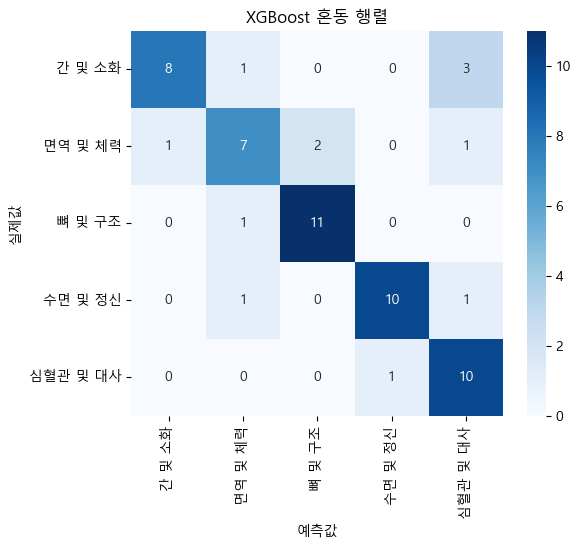

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 📌 데이터 불러오기
individual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\individual_data.xlsx')
nonindividual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\nonindividual_data.xlsx')
symptom_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\symptom_final_data.xlsx')

# 개인형 & 비개인형 데이터 결합
individual_data['형태'] = '개별 인정형 품목'
nonindividual_data['형태'] = '고시형 품목'
combined_data = pd.concat([individual_data, nonindividual_data], ignore_index=True)

# 📌 SBERT 모델 로드 (한국어 특화 모델)
# Load model directly
from transformers import AutoTokenizer, AutoModel

# 📌 KoSimCSE 모델 로드
model_name = "BM-K/KoSimCSE-roberta-multitask"
tokenizer = AutoTokenizer.from_pretrained(model_name)
symptom_model = AutoModel.from_pretrained(model_name)
warning_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

# 📌 증상-건강 카테고리 매핑 추가
symptom_to_category = {
    "가슴이 답답하다": "심혈관 및 대사",
    "숨이 차다": "심혈관 및 대사",
    "심장이 두근거린다": "심혈관 및 대사",
    "혈압이 높다": "심혈관 및 대사",
    "손발이 차다": "심혈관 및 대사",
    "당뇨가 있다": "심혈관 및 대사",
    "살이 많이 찐다": "심혈관 및 대사",
    "비만이 걱정된다": "심혈관 및 대사",
    "고혈당이 있다": "심혈관 및 대사",
    "속이 메스껍다": "간 및 소화",
    "속이 쓰리다": "간 및 소화",
    "가스가 자주 찬다": "간 및 소화",
    "소화가 잘 안된다": "간 및 소화",
    "소변 색이 짙다": "간 및 소화",
    "변비가 있다": "간 및 소화",
    "설사를 자주 한다": "간 및 소화",
    "복부팽만감이 있다": "간 및 소화",
    "감기에 자주 걸린다": "면역 및 체력",
    "몸이 쉽게 피곤하다": "면역 및 체력", 
    "콧물이 난다.": "면역 및 체력",
    "기운이 없다": "면역 및 체력",
    "너무 춥다.": "면역 및 체력",
    "근육통이 있다": "면역 및 체력",
    "면역력이 약하다": "면역 및 체력",
    "잠을 잘 못 잔다": "수면 및 정신",
    "스트레스를 많이 받는다": "수면 및 정신",
    "우울감을 느낀다": "수면 및 정신",
    "불안하다": "수면 및 정신",
    "집중력이 떨어진다": "수면 및 정신",
    "무릎이 아프다": "뼈 및 구조",
    "허리가 아프다": "뼈 및 구조",
    "관절이 뻣뻣하다": "뼈 및 구조",
    "골다공증이 걱정된다": "뼈 및 구조",
    "등이 결린다": "뼈 및 구조"
}

# 증상 데이터에 추가
symptom_df = pd.DataFrame(list(symptom_to_category.items()), columns=['text', '건강 카테고리'])
symptom_data = pd.concat([symptom_data, symptom_df], ignore_index=True)

# 🔧문장을 벡터로 변환하는 함수
# def encode_text(text):
#     inputs = tokenizer([text], return_tensors="pt", padding=True, truncation=True, max_length=128)
#     with torch.no_grad():
#         outputs = symptom_model(**inputs)
#     return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# 🔧 문장을 SBERT 벡터로 변환하는 함수 (Mean Pooling 적용)
def encode_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = symptom_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

# 📌 SBERT 벡터화
symptom_vectors = np.array([encode_text(text) for text in symptom_data['text']])
# 📌 라벨 인코딩
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(symptom_data['건강 카테고리'])

# 🚨 SMOTE 적용
smote = SMOTE(sampling_strategy='auto', random_state=42)  
X_resampled, y_resampled = smote.fit_resample(symptom_vectors, encoded_labels)
# 🚨 train-test split 수정: stratify를 올바르게 설정
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 모델 학습 시 과적합 방지를 위한 하이퍼파라미터 조정
from xgboost import XGBClassifier

# ✅ XGBoost 모델 생성 (eval_metric과 early_stopping_rounds를 생성자에서 설정)
model = XGBClassifier(
    n_estimators=500, 
    learning_rate=0.01, 
    max_depth=4, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    eval_metric="mlogloss",  # 다중 분류 설정
    early_stopping_rounds=50, 
    random_state=42
)
# ✅ 모델 학습
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=True)

# ✅ 예측 수행
y_pred = model.predict(X_test)

# ✅ 정확도 출력
accuracy = accuracy_score(y_test, y_pred)
print(f"📈 모델 정확도: {accuracy:.4f}")


# 📌 Validation 평가 추가
y_valid_pred = model.predict(X_valid)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"📊 Validation 데이터 정확도: {valid_accuracy:.4f}")
print(classification_report(y_valid, y_valid_pred, target_names=label_encoder.classes_))

# 📌 Test 평가
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"📈 Test 데이터 정확도: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


# 정밀도, 재현율, F1-score 출력
print("\n📊 분류 성능 보고서 (Classification Report):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("예측값")
plt.ylabel("실제값")
plt.title("XGBoost 혼동 행렬")
plt.show()


# 📌 지병 및 특이사항 필터링 함수
def is_safe_for_condition(product_warning, user_condition, threshold=0.45):
    if isinstance(product_warning, float) and pd.isna(product_warning):
        return True
    bullets = product_warning.split('\n')
    for bullet in bullets:
        bullet = bullet.strip()
        if bullet == "":
            continue
        sim = util.cos_sim(warning_model.encode(bullet).reshape(1, -1), warning_model.encode(user_condition).reshape(1, -1))[0][0].item()
        if sim >= threshold:
            return False
    return True

# 📌 추천 함수 (고시형/개별 인정형 포함)
def recommend_health_products(user_input, user_condition, top_n=5):
    input_vector = encode_text(user_input).reshape(1, -1)
    
   # 증상과 가장 유사한 건강 카테고리 예측
    symptom_similarities = [
        (util.cos_sim(input_vector, encode_text(row['text']).reshape(1, -1))[0][0].item(), row['건강 카테고리']) 
        for _, row in symptom_data.iterrows()
    ]
    predicted_category = max(symptom_similarities, key=lambda x: x[0])[1]

    
    # 추천 제품 필터링 (고시형/개별 인정형 포함)
    recommended_products = [
        (row['품목명'], row['형태'], row['건강 카테고리'])
        for _, row in combined_data.iterrows() 
        if row['건강 카테고리'] == predicted_category
    ]
    recommended_products = sorted(recommended_products, key=lambda x: x[1], reverse=True)[:top_n]

    # 추천할 제품이 없으면 메시지 출력 후 종료
    if not recommended_products:
        print("\n⚠ 추천할 제품이 없습니다.")
        return

    print(f"\n🧠 예측된 건강 카테고리: {predicted_category}")
    print(f"💊 최종 추천 건강기능식품:")

    # 오류 방지를 위해 개수 확인 후 출력
    for idx, item in enumerate(recommended_products):
        if len(item) == 2:  # 제품명과 유사도만 있는 경우
            name, sim_score = item
            print(f"{idx+1}. {name} (유사도: {sim_score:.4f})")
        elif len(item) == 3:  # 제품 유형까지 있는 경우
            name, kind, category = item
            print(f"{idx+1}. {name} ({kind}, {category})")
            
    
            

In [2]:
# 📌 예제 실행
user_input = "스트레스 받아요"
user_condition = "임산부"
recommend_health_products(user_input, user_condition, top_n=3)


🧠 예측된 건강 카테고리: 수면 및 정신
💊 최종 추천 건강기능식품:
1. 은행잎 추출물 (고시형 품목, 수면 및 정신)
2. 홍경천 추출물 (고시형 품목, 수면 및 정신)
3. 마리골드꽃추출물 (고시형 품목, 수면 및 정신)
